# Anonymous Feature Correlation Notebook

This notebook correlates the anonymous features from `train.csv` with public, open-source data from **Yahoo Finance** and **FRED (Federal Reserve Economic Data)**.

**Objective:** To de-anonymize the features by finding strong correlations with real-world indicators.

**Logic:**
1.  **Install** required libraries.
2.  **Load Public Data:** Download 10+ years of daily data from Yahoo (`yfinance`) and FRED (`fredapi`).
3.  **Load Anonymous Data:** Load the `train.csv` file.
4.  **Map Dates:** Replicate the logic from the original notebook. We assume the `N` unique `date_id`s in `train.csv` map sequentially to the *last N* trading days of the S&P 500 (`^GSPC`) data.
5.  **Merge Data:** Join all dataframes on the mapped `Date`.
6.  **Calculate & Show Correlations:** Find the strongest (positive and negative) correlations between the anonymous and public features.

In [1]:
%pip install polars pandas yfinance fredapi --quiet

DEPRECATION: Loading egg at /home/paul/anaconda3/envs/ml_311/lib/python3.11/site-packages/ete3-3.1.3-py3.10.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
Note: you may need to restart the kernel to use updated packages.


In [2]:
import polars as pl
import pandas as pd
import yfinance as yf
from fredapi import Fred
import io

print("Libraries imported.")

Libraries imported.


## Part 1: Load Open-Source Public Data

First, we define our date range and the public tickers/series we want to check.

In [3]:
# --- Parameters ---
START_DATE = "2005-01-01"
END_DATE = "2025-08-31"


TRAIN_DATA_PATH = "./kaggle/train.csv"
SPY_DATE_PATH = "./kaggle/spy-historical.csv"  # Public SPY dates data

In [4]:
# --- 2. Load Public Data ---
import yfinance as yf
from fredapi import Fred
import polars as pl
from datetime import datetime
import pandas as pd
import dotenv

# *** START OF UPDATE ***

# --- Configuration ---
START_DATE = "2010-01-01"
END_DATE = datetime.now().strftime('%Y-%m-%d')
FRED_API_KEY = dotenv.get_key(dotenv.find_dotenv(), "FRED_API_KEY")

# Define tickers and FRED series IDs by category
YFINANCE_TICKERS = {
    # M* - Market Dynamics/Technical
    'M_GSPC': '^GSPC',        # S&P 500 Index
    'M_IXIC': '^IXIC',        # NASDAQ Composite
    'M_DJI': '^DJI',          # Dow Jones Industrial Average
    'M_RUT': '^RUT',          # Russell 2000

    # V* - Volatility
    'V_VIX': '^VIX',          # CBOE Volatility Index
    #'V_VXN': '^VXN',          # CBOE NASDAQ 100 Volatility Index
    'V_VIX3M': '^VIX3M',      # CBOE 3 Month Volatility Index

    # P* - Price/Valuation
    'P_GC=F': 'GC=F',         # Gold Futures
    'P_CL=F': 'CL=F',         # Crude Oil Futures
    'P_SI=F': 'SI=F',         # Silver Futures
    'P_HG=F': 'HG=F',         # Copper Futures

    # I* - Interest Rates (from Yahoo)
    'I_FVX': '^FVX',          # Treasury Yield 5 Years
    'I_TNX': '^TNX',          # CBOE Interest Rate 10 Year T Note
    'I_TYX': '^TYX',          # Treasury Yield 30 Years
    
    # S* - Sentiment/Alternative
    'S_BTC-USD': 'BTC-USD',   # Bitcoin
}

FRED_SERIES = {
    # E* - Macro Economic
    'E_GDP': 'GDP',                       # Gross Domestic Product
    'E_UNRATE': 'UNRATE',                 # Unemployment Rate
    'E_CPIAUCSL': 'CPIAUCSL',             # Consumer Price Index
    'E_PPIACO': 'PPIACO',                 # Producer Price Index
    'E_INDPRO': 'INDPRO',                 # Industrial Production Index
    'E_PAYEMS': 'PAYEMS',                 # Non-Farm Payrolls
    'E_ICSA': 'ICSA',                     # Initial Claims

    # I* - Interest Rates
    'I_DFF': 'DFF',                       # Federal Funds Effective Rate
    'I_DTB3': 'DTB3',                     # 3-Month Treasury Bill
    'I_DGS2': 'DGS2',                     # 2-Year Treasury Yield
    'I_DGS10': 'DGS10',                   # 10-Year Treasury Yield
    'I_T10Y2Y': 'T10Y2Y',                 # 10-Year vs 2-Year Treasury Spread

    # V* - Volatility
    # 'V_VIXCLS': 'VIXCLS',                 # VIX (from FRED)

    # S* - Sentiment
    'S_UMCSENT': 'UMCSENT',               # University of Michigan Consumer Sentiment
    'S_BAMLH0A0HYM2': 'BAMLH0A0HYM2',    # BofA US High Yield Index Option-Adjusted Spread
    'S_EMVMACROBUS': 'EMVMACROBUS',      #Equity Market Volatility Tracker: Macroeconomic News and Outlook: Business Investment And Sentiment
}



# --- Data Fetching Functions ---
def fetch_yfinance_data(tickers, start, end):
    """Fetches and processes data from Yahoo Finance."""
    print(f"Fetching {len(tickers)} tickers from Yahoo Finance...")
    df = yf.download(list(tickers.values()), start=start, end=end, progress=False)
    
    # Use only 'Adj Close' and rename columns to custom names
    df = df['Close']
    df = df.rename(columns={v: k for k, v in tickers.items()})
    
    df = df.reset_index()
    return pl.from_pandas(df)

def fetch_fred_data(series_ids, api_key, start, end):
    """Fetches and processes data from FRED."""
    print(f"Fetching {len(series_ids)} series from FRED...")
    try:
        fred = Fred(api_key=api_key)
    except ValueError as e:
        print(f"Error initializing Fred API: {e}")
        print("Please make sure you have set a valid FRED_API_KEY.")
        return pl.DataFrame()

    # Fetch all series
    df_list = []
    for code, name in series_ids.items():
        try:
            s = fred.get_series(name, start_date=start, end_date=end)
            s.name = code
            df_list.append(s)
        except Exception as e:
            print(f"Could not fetch series {name} ({code}): {e}")
            
    if not df_list:
        print("No data fetched from FRED.")
        return pl.DataFrame()
    
    # Combine into a single DataFrame
    df = pd.concat(df_list, axis=1).reset_index()
    df = df.rename(columns={'index': 'Date'})
    return pl.from_pandas(df)

# --- Fetch and Process Data ---
yf_data = fetch_yfinance_data(YFINANCE_TICKERS, START_DATE, END_DATE)
fred_data = fetch_fred_data(FRED_SERIES, FRED_API_KEY, START_DATE, END_DATE)


Fetching 14 tickers from Yahoo Finance...


/tmp/ipykernel_4983/3695140231.py:76: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(list(tickers.values()), start=start, end=end, progress=False)


Fetching 15 series from FRED...


In [5]:
# Define momentum periods (in days)
MOMENTUM_PERIODS = [21] # 1 week, 1 month, 6 months
MOMENTUM_PERIODS = []
# Ensure Date columns are of the same type
yf_data = yf_data.with_columns(pl.col("Date").cast(pl.Date))
if not fred_data.is_empty():
    fred_data = fred_data.with_columns(pl.col("Date").cast(pl.Date))

    # Join the two public datasets
    public_data = yf_data.join(fred_data, on='Date', how='left')
else:
    public_data = yf_data

# Sort and forward-fill missing values (common for economic data)
public_data = public_data.sort("Date").fill_null(strategy='forward')

# --- Calculate Momentum Features ---
mom_features = []
for col in public_data.columns:
    if col != 'Date': # Don't calculate momentum on the date column
        for period in MOMENTUM_PERIODS:
            # Calculate rolling average (SMA)
            sma_col_name = f"SMA_{period}D_{col}"
            public_data = public_data.with_columns(
                pl.col(col).rolling_mean(window_size=period).alias(sma_col_name)
            )
            
            # # Calculate Rate of Change (ROC)
            # roc_col_name = f"MOM_ROC_{period}D_{col}"
            # public_data = public_data.with_columns(
            #     ((pl.col(col) / pl.col(col).shift(period)) - 1).alias(roc_col_name)
            # )
            

# Drop rows with nulls created by momentum calculations
# public_data = public_data.drop_nulls()

print("\n--- Public Data Shape ---")
print(public_data.shape)
print("\n--- Public Data Head ---")
print(public_data.head())

# *** END OF UPDATE ***


--- Public Data Shape ---
(5272, 30)

--- Public Data Head ---
shape: (5, 30)
┌───────────┬───────────┬───────────┬───────────┬───┬──────────┬───────────┬───────────┬───────────┐
│ Date      ┆ S_BTC-USD ┆ P_CL=F    ┆ P_GC=F    ┆ … ┆ I_T10Y2Y ┆ S_UMCSENT ┆ S_BAMLH0A ┆ S_EMVMACR │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---      ┆ ---       ┆ 0HYM2     ┆ OBUS      │
│ date      ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64      ┆ f64       ┆ ---       ┆ ---       │
│           ┆           ┆           ┆           ┆   ┆          ┆           ┆ f64       ┆ f64       │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪══════════╪═══════════╪═══════════╪═══════════╡
│ 2010-01-0 ┆ null      ┆ 81.510002 ┆ 1117.6999 ┆ … ┆ 2.76     ┆ null      ┆ 6.34      ┆ null      │
│ 4         ┆           ┆           ┆ 51        ┆   ┆          ┆           ┆           ┆           │
│ 2010-01-0 ┆ null      ┆ 81.769997 ┆ 1118.0999 ┆ … ┆ 2.76     ┆ null      ┆ 6.3       ┆ null      │
│ 5         

## Part 2: Load and Map Anonymous Data

Here, we replicate the **exact date-mapping logic** from your original notebook. We use the `SPY_Close` data (downloaded as `^GSPC`) as the ground truth for trading days, just as your notebook used `spy-historical.csv`.

In [7]:

# Run the mapping
df_spy = pl.read_csv(SPY_DATE_PATH)
df_spy_date = df_spy.with_columns(pl.col("Date").str.to_date().alias("Date"))


"""Loads train.csv and maps date_id to actual dates."""

df_train = pl.read_csv(TRAIN_DATA_PATH)
df_train = df_train.slice(3000)
#print(df_train.glimpse())
anonymous_features = [col for col in df_train.columns if any(col.startswith(p) for p in ['M', 'E', 'I', 'P', 'V', 'S', 'D', 'MOM'])]
string_features_to_convert = []

for col_name in anonymous_features:
    if df_train[col_name].dtype == pl.String:
        string_features_to_convert.append(col_name)

if string_features_to_convert:
    print(f"Found {len(string_features_to_convert)} string columns to convert: {string_features_to_convert}")
    
    # 4. Convert them, turning bad values (like "N/A") into nulls
    df_train = df_train.with_columns(
        pl.col(string_features_to_convert).cast(pl.Float64, strict=False)
    )

# 1. Get unique, sorted date_ids from training data
unique_date_ids = df_train["date_id"].unique().sort()
n_dates_train = len(unique_date_ids)
print(f"Found {n_dates_train} unique date_ids in train.csv.")

# 2. Get the *last N* trading days from our public SPY data
# (This is the CRITICAL ASSUMPTION from your notebook)
spy_ground_truth_dates = df_spy_date.sort("date_id").tail(n_dates_train)["Date"]

if len(spy_ground_truth_dates) != n_dates_train:
    print("Error: Mismatch in date counts. Cannot perform mapping.")

# 3. Create the mapping dataframe
date_map = pl.DataFrame({
    "date_id": unique_date_ids,
    "Date": spy_ground_truth_dates
})

# print("Date mapping created. Example:")
# print(date_map.head(3))
# print("...")
# print(date_map.tail(3))

# 4. Join the map back to the training data
df_train_with_dates = df_train.join(date_map, on="date_id", how="left")
print(df_train_with_dates.head())


Found 85 string columns to convert: ['E1', 'E10', 'E11', 'E12', 'E13', 'E14', 'E15', 'E16', 'E17', 'E18', 'E19', 'E2', 'E20', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'M1', 'M10', 'M11', 'M12', 'M13', 'M14', 'M15', 'M16', 'M17', 'M18', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'P1', 'P10', 'P11', 'P12', 'P13', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'S1', 'S10', 'S11', 'S12', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'V1', 'V10', 'V11', 'V12', 'V13', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9']
Found 5990 unique date_ids in train.csv.
shape: (5, 99)
┌─────────┬─────┬─────┬─────┬───┬─────────────────┬────────────────┬──────────────────┬────────────┐
│ date_id ┆ D1  ┆ D2  ┆ D3  ┆ … ┆ forward_returns ┆ risk_free_rate ┆ market_forward_e ┆ Date       │
│ ---     ┆ --- ┆ --- ┆ --- ┆   ┆ ---             ┆ ---            ┆ xcess_returns    ┆ ---        │
│ i64     ┆ i64 ┆ i64 ┆ i64 ┆   ┆ f64             ┆ f64        

In [14]:
#visualize the result
print("\n--- Training Data with Dates Shape ---")
import numpy as np
import scipy
import matplotlib.pyplot as plt
import plotly.graph_objects as go

plotfeatures = ["M16","M18"]
plotfeatures = anonymous_features
plotfeatures = ["V13","M1","S5","D2","D1","M2","V10",'M4','S2','P8','E7']
target_col = "market_forward_excess_returns"

# Pre-extract the target column and Date
# Using .iloc[:, 0] ensures we get a Series for calculations
target_series = df_train_with_dates.select(target_col).to_pandas().iloc[:, 0]
date_series = df_train_with_dates.select("Date").to_pandas().iloc[:, 0]

for fs in plotfeatures:
    # Extract feature data
    feature_series = df_train_with_dates.select(fs).to_pandas().iloc[:, 0]

    # --- 1. Interactive Time Series Plot ---
    fig_ts = go.Figure()
    fig_ts.add_trace(go.Scatter(
        x=date_series, 
        y=feature_series, 
        mode='lines+markers', 
        name=fs,
        marker=dict(size=4)
    ))
    fig_ts.update_layout(
        title=f"Time Series of {fs} (Interactive)",
        xaxis_title="Date",
        yaxis_title=fs,
        template="plotly_white",
        height=500
    )
    fig_ts.show()

    # --- 2. Interactive 30-Day Rolling Correlation ---
    # Calculate rolling correlation
    rolling_corr = feature_series.rolling(window=30).corr(target_series)

    fig_corr = go.Figure()
    fig_corr.add_trace(go.Scatter(
        x=date_series, 
        y=rolling_corr, 
        mode='lines', 
        name='Rolling Correlation',
        line=dict(color='orange', width=2)
    ))
    # Add a zero reference line
    fig_corr.add_shape(type="line",
        x0=date_series.iloc[0], y0=0, x1=date_series.iloc[-1], y1=0,
        line=dict(color="black", width=1, dash="dash")
    )
    fig_corr.update_layout(
        title=f"30-Day Rolling Correlation: {fs} vs {target_col}",
        xaxis_title="Date",
        yaxis_title="Correlation",
        template="plotly_white",
        height=500
    )
    fig_corr.show()

    # --- 3. Interactive Fourier Transform ---
    freqdata = np.fft.fft(feature_series.to_numpy().flatten())
    freqdata = np.abs(freqdata)
    
    # fig_fft = go.Figure()
    # fig_fft.add_trace(go.Scatter(
    #     y=freqdata, 
    #     mode='lines+markers', 
    #     name='FFT',
    #     marker=dict(size=4)
    # ))
    # fig_fft.update_layout(
    #     title=f"FFT of {fs}",
    #     xaxis_title="k (Frequency)",
    #     yaxis_title=f"abs FFT({fs})",
    #     template="plotly_white",
    #     height=500
    # )
    # fig_fft.show()

    # Print 10 highest frequencies
    freq_indices = np.argsort(freqdata)[-10:][::-1]
    print(f"Top 10 frequencies for {fs}:")
    for idx in freq_indices:
        print(f"  k={idx}, abs FFT={freqdata[idx]:.4f}")


--- Training Data with Dates Shape ---


Top 10 frequencies for V13:
  k=2, abs FFT=2059.0653
  k=5988, abs FFT=2059.0653
  k=4, abs FFT=1585.9479
  k=5986, abs FFT=1585.9479
  k=5987, abs FFT=844.4181
  k=3, abs FFT=844.4181
  k=8, abs FFT=781.4469
  k=5982, abs FFT=781.4469
  k=5983, abs FFT=737.4522
  k=7, abs FFT=737.4522


Top 10 frequencies for M1:
  k=1990, abs FFT=nan
  k=1991, abs FFT=nan
  k=1992, abs FFT=nan
  k=1993, abs FFT=nan
  k=1994, abs FFT=nan
  k=1995, abs FFT=nan
  k=1996, abs FFT=nan
  k=1997, abs FFT=nan
  k=1998, abs FFT=nan
  k=1999, abs FFT=nan


Top 10 frequencies for S5:
  k=5801, abs FFT=502.8680
  k=189, abs FFT=502.8680
  k=5866, abs FFT=462.4730
  k=124, abs FFT=462.4730
  k=5859, abs FFT=460.7883
  k=131, abs FFT=460.7883
  k=5843, abs FFT=456.4767
  k=147, abs FFT=456.4767
  k=80, abs FFT=403.8681
  k=5910, abs FFT=403.8681


Top 10 frequencies for D2:
  k=0, abs FFT=189.0000
  k=190, abs FFT=107.4825
  k=5800, abs FFT=107.4825
  k=191, abs FFT=95.2346
  k=5799, abs FFT=95.2346
  k=1051, abs FFT=86.9412
  k=4939, abs FFT=86.9412
  k=5609, abs FFT=84.6675
  k=381, abs FFT=84.6675
  k=4749, abs FFT=64.1174


Top 10 frequencies for D1:
  k=0, abs FFT=189.0000
  k=190, abs FFT=107.4825
  k=5800, abs FFT=107.4825
  k=191, abs FFT=95.2346
  k=5799, abs FFT=95.2346
  k=1051, abs FFT=86.9412
  k=4939, abs FFT=86.9412
  k=5609, abs FFT=84.6675
  k=381, abs FFT=84.6675
  k=4749, abs FFT=64.1174


Top 10 frequencies for M2:
  k=1990, abs FFT=nan
  k=1991, abs FFT=nan
  k=1992, abs FFT=nan
  k=1993, abs FFT=nan
  k=1994, abs FFT=nan
  k=1995, abs FFT=nan
  k=1996, abs FFT=nan
  k=1997, abs FFT=nan
  k=1998, abs FFT=nan
  k=1999, abs FFT=nan


Top 10 frequencies for V10:
  k=1990, abs FFT=nan
  k=1991, abs FFT=nan
  k=1992, abs FFT=nan
  k=1993, abs FFT=nan
  k=1994, abs FFT=nan
  k=1995, abs FFT=nan
  k=1996, abs FFT=nan
  k=1997, abs FFT=nan
  k=1998, abs FFT=nan
  k=1999, abs FFT=nan


Top 10 frequencies for M4:
  k=5915, abs FFT=414.0330
  k=75, abs FFT=414.0330
  k=247, abs FFT=383.0035
  k=5743, abs FFT=383.0035
  k=245, abs FFT=382.8251
  k=5745, abs FFT=382.8251
  k=303, abs FFT=351.8522
  k=5687, abs FFT=351.8522
  k=5630, abs FFT=348.8470
  k=360, abs FFT=348.8470


Top 10 frequencies for S2:
  k=5983, abs FFT=894.7670
  k=7, abs FFT=894.7670
  k=5966, abs FFT=842.7679
  k=24, abs FFT=842.7679
  k=16, abs FFT=626.4089
  k=5974, abs FFT=626.4089
  k=5946, abs FFT=618.4439
  k=44, abs FFT=618.4439
  k=49, abs FFT=617.2998
  k=5941, abs FFT=617.2998


Top 10 frequencies for P8:
  k=0, abs FFT=8484.0719
  k=5986, abs FFT=1629.1942
  k=4, abs FFT=1629.1942
  k=5987, abs FFT=1485.8178
  k=3, abs FFT=1485.8178
  k=7, abs FFT=934.8965
  k=5983, abs FFT=934.8965
  k=5989, abs FFT=883.7705
  k=1, abs FFT=883.7705
  k=2, abs FFT=772.3074


Top 10 frequencies for E7:
  k=1990, abs FFT=nan
  k=1991, abs FFT=nan
  k=1992, abs FFT=nan
  k=1993, abs FFT=nan
  k=1994, abs FFT=nan
  k=1995, abs FFT=nan
  k=1996, abs FFT=nan
  k=1997, abs FFT=nan
  k=1998, abs FFT=nan
  k=1999, abs FFT=nan


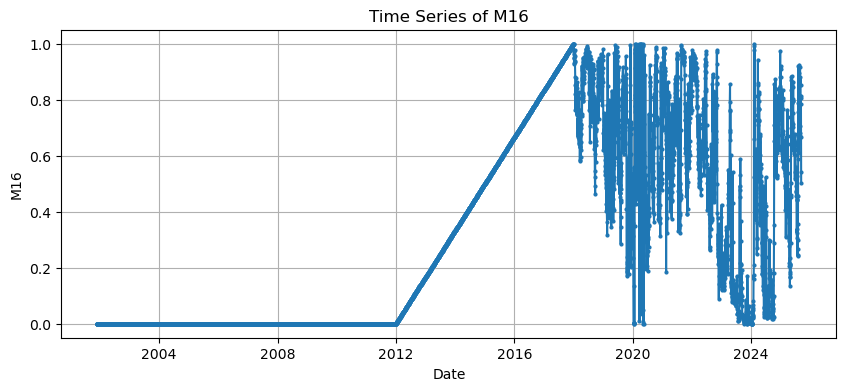

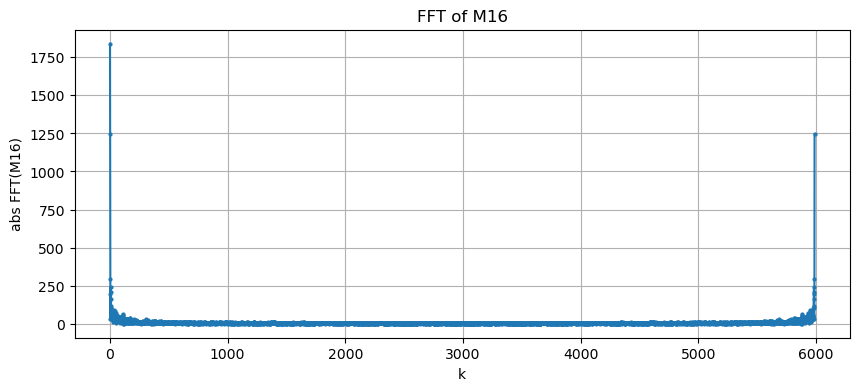

Top 10 frequencies for M16:
  k=0, abs FFT=1839.178571428571
  k=1, abs FFT=1246.5725817393768
  k=5989, abs FFT=1246.5725817393766
  k=2, abs FFT=293.2041187289779
  k=5988, abs FFT=293.20411872897785
  k=5984, abs FFT=240.18479261395282
  k=6, abs FFT=240.1847926139528
  k=7, abs FFT=208.4078000605568
  k=5983, abs FFT=208.4078000605568
  k=3, abs FFT=192.11617909551788


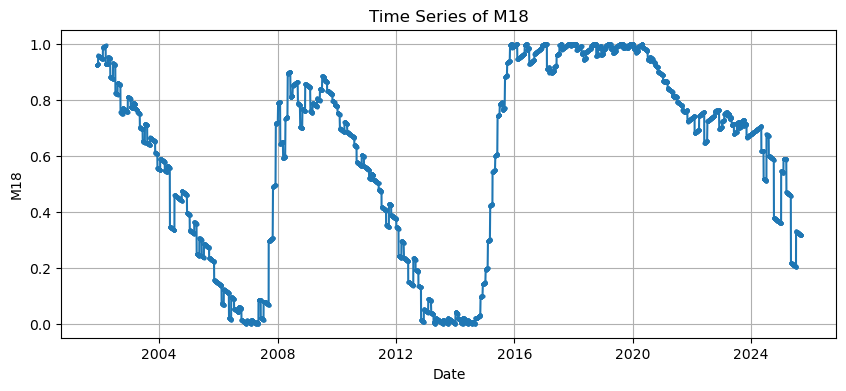

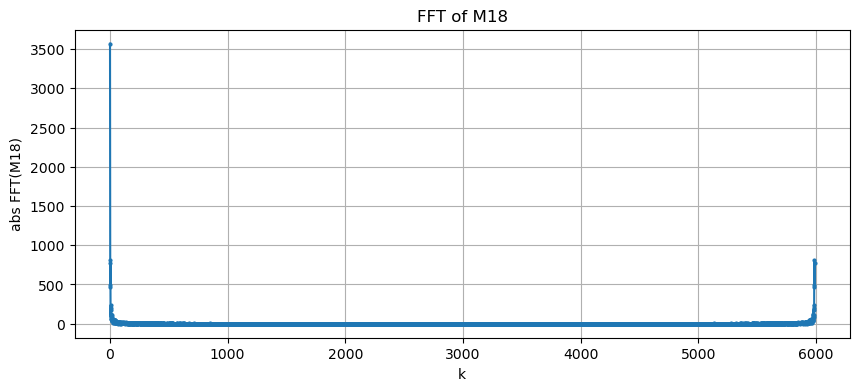

Top 10 frequencies for M18:
  k=0, abs FFT=3568.4847883597877
  k=3, abs FFT=807.8254995540201
  k=5987, abs FFT=807.8254995540195
  k=1, abs FFT=775.9237064816621
  k=5989, abs FFT=775.923706481662
  k=4, abs FFT=496.7012869729183
  k=5986, abs FFT=496.70128697291824
  k=2, abs FFT=466.3981966326996
  k=5988, abs FFT=466.39819663269947
  k=7, abs FFT=235.53315653685203


In [11]:
#visualize the resultprint("\n--- Training Data with Dates Shape ---")
import numpy as np
import scipy

import matplotlib.pyplot as plt
plotfeatures = ["M16","M18"]
#plotfeatures = anonymous_features
for fs in plotfeatures:
    plt.figure(figsize=(10, 4))
    plt.plot(df_train_with_dates.select("Date").to_pandas(), df_train_with_dates.select(fs).to_pandas(), marker='o', linestyle='-', markersize=2)
    plt.title(f"Time Series of {fs}")
    plt.xlabel("Date")
    plt.ylabel(fs)
    plt.grid()
    plt.show()
    # plot fourier transform
    plt.figure(figsize=(10, 4))
    freqdata = np.fft.fft(df_train_with_dates.select(fs).to_numpy().flatten())
    freqdata = np.abs(freqdata)
    #print(freqdata[1:10])
    plt.plot(freqdata, marker='o', linestyle='-', markersize=2)
    plt.title(f"FFT of {fs}")
    plt.xlabel("k")
    plt.ylabel(f"abs FFT({fs})")
    plt.grid()
    plt.show()
    # print 10 highest frequencies
    freq_indices = np.argsort(freqdata)[-10:][::-1]
    print(f"Top 10 frequencies for {fs}:")
    for idx in freq_indices:
        print(f"  k={idx}, abs FFT={freqdata[idx]}")

## Part 3: Merge All Data Sources

Now we combine everything into one master dataframe. We'll use the `df_train_with_dates` as our base, then join the Yahoo and FRED data to it.

We must **forward-fill** the FRED data, as it's reported on all days (including weekends) or only when it changes (like `FED_FUNDS`). Forward-filling applies the last known value to the trading days.

In [20]:

# Join all dataframes
df_merged = df_train_with_dates.join(public_data, on="Date", how="left")

# Forward-fill nulls in public data (especially for FRED data)
public_feature_cols = list(YFINANCE_TICKERS.keys()) + list(FRED_SERIES.keys())
#public_feature_cols = [f"{col}_Close" if col in YFINANCE_TICKERS.values() else col for col in public_feature_cols]
public_feature_cols = public_data.columns[1:]  # Exclude 'Date' column

# df_merged = df_merged.with_columns(
#     pl.col(public_feature_cols).forward_fill()
# )

# Drop any remaining nulls (e.g., at the very start of the history)
df_merged = df_merged.drop_nulls().drop_nans()

print("Master dataframe created. Shape:", df_merged.shape)
print(df_merged.tail())
df_numeric_features = df_merged.select([pl.selectors.numeric()])
print(f"\nNumeric features dataframe shape: {df_numeric_features.shape}")

Master dataframe created. Shape: (2021, 128)
shape: (5, 128)
┌─────────┬─────┬─────┬─────┬───┬──────────┬───────────┬────────────────┬───────────────┐
│ date_id ┆ D1  ┆ D2  ┆ D3  ┆ … ┆ I_T10Y2Y ┆ S_UMCSENT ┆ S_BAMLH0A0HYM2 ┆ S_EMVMACROBUS │
│ ---     ┆ --- ┆ --- ┆ --- ┆   ┆ ---      ┆ ---       ┆ ---            ┆ ---           │
│ i64     ┆ i64 ┆ i64 ┆ i64 ┆   ┆ f64      ┆ f64       ┆ f64            ┆ f64           │
╞═════════╪═════╪═════╪═════╪═══╪══════════╪═══════════╪════════════════╪═══════════════╡
│ 8985    ┆ 0   ┆ 0   ┆ 0   ┆ … ┆ 0.59     ┆ 58.2      ┆ 2.83           ┆ 0.0           │
│ 8986    ┆ 0   ┆ 0   ┆ 0   ┆ … ┆ 0.56     ┆ 58.2      ┆ 2.84           ┆ 0.0           │
│ 8987    ┆ 0   ┆ 0   ┆ 1   ┆ … ┆ 0.54     ┆ 58.2      ┆ 2.87           ┆ 0.0           │
│ 8988    ┆ 0   ┆ 0   ┆ 0   ┆ … ┆ 0.5      ┆ 58.2      ┆ 2.84           ┆ 0.0           │
│ 8989    ┆ 0   ┆ 0   ┆ 0   ┆ … ┆ 0.49     ┆ 58.2      ┆ 2.78           ┆ 0.0           │
└─────────┴─────┴─────┴─────┴───┴──────

In [41]:
#visualize the resultprint("\n--- Training Data with Dates Shape ---")
print(df_merged.shape)
print("\n--- Training Data with Dates Head ---")
print(df_merged.head())
import matplotlib.pyplot as plt
plotfeatures = ["M16","M18"]
plotfeatures = anonymous_features
for fs in plotfeatures:
    break
    plt.figure(figsize=(6, 4))
    plt.plot(df_merged.select("Date").to_pandas(), df_merged.select(fs).to_pandas(), marker='o', linestyle='-', markersize=2)
    plt.title(f"Time Series of {fs}")
    plt.xlabel("Date")
    plt.ylabel(fs)
    plt.grid()
    plt.show()

(2021, 128)

--- Training Data with Dates Head ---
shape: (5, 128)
┌─────────┬─────┬─────┬─────┬───┬──────────┬───────────┬────────────────┬───────────────┐
│ date_id ┆ D1  ┆ D2  ┆ D3  ┆ … ┆ I_T10Y2Y ┆ S_UMCSENT ┆ S_BAMLH0A0HYM2 ┆ S_EMVMACROBUS │
│ ---     ┆ --- ┆ --- ┆ --- ┆   ┆ ---      ┆ ---       ┆ ---            ┆ ---           │
│ i64     ┆ i64 ┆ i64 ┆ i64 ┆   ┆ f64      ┆ f64       ┆ f64            ┆ f64           │
╞═════════╪═════╪═════╪═════╪═══╪══════════╪═══════════╪════════════════╪═══════════════╡
│ 6969    ┆ 0   ┆ 0   ┆ 0   ┆ … ┆ 0.83     ┆ 96.8      ┆ 3.88           ┆ 0.47176       │
│ 6970    ┆ 0   ┆ 0   ┆ 0   ┆ … ┆ 0.8      ┆ 96.8      ┆ 3.9            ┆ 0.47176       │
│ 6971    ┆ 0   ┆ 0   ┆ 0   ┆ … ┆ 0.82     ┆ 96.8      ┆ 3.86           ┆ 0.47176       │
│ 6972    ┆ 0   ┆ 0   ┆ 0   ┆ … ┆ 0.79     ┆ 96.8      ┆ 3.85           ┆ 0.47176       │
│ 6973    ┆ 0   ┆ 0   ┆ 0   ┆ … ┆ 0.81     ┆ 95.1      ┆ 3.82           ┆ 0.17242       │
└─────────┴─────┴─────┴─────┴───┴

## Part 4: Calculate and Display Correlations

Finally, we calculate the correlation matrix. To make it easy to read, we won't print the whole matrix. Instead, we'll:

1.  Isolate the correlations between *anonymous* and *public* features.
2.  "Melt" the matrix into a long list: `(anonymous_feature, public_feature, correlation)`.
3.  Sort by the **absolute correlation value** to find the strongest relationships (both positive and negative).

In [23]:

# Define our two feature groups
public_features = public_feature_cols
#anonymous_features = [col for col in df_numeric_features.columns if col not in public_features and any(col.startswith(p) for p in ['M', 'E', 'I', 'P', 'V', 'S', 'D', 'MOM'])]

all_features = anonymous_features + public_features

print(f"\nAnonymous features ({len(anonymous_features)}): {anonymous_features}")
print(f"Public features ({len(public_features)}): {public_features}")

print(f"Correlating {len(anonymous_features)} anonymous features with {len(public_features)} public features...")

# Calculate the full correlation matrix for our subset of columns
corr_matrix = df_merged.select(anonymous_features + public_features).corr()

# *** START OF FIX ***

# Manually add the feature names as a new column
# This is the column we will filter on.
corr_matrix_with_labels = corr_matrix.with_columns(
    pl.Series("anonymous_feature", all_features)
)

# Filter the matrix to only show (Anonymous Rows x Public Columns)
corr_subset = corr_matrix_with_labels.filter(
    pl.col("anonymous_feature").is_in(anonymous_features)
).select(
    ["anonymous_feature"] + public_features  # Use the new column name
)

# Melt the matrix to a long format for easy sorting
corr_long = corr_subset.unpivot(
    index="anonymous_feature",  # Use the new column name
    variable_name="public_feature", 
    value_name="correlation"
)

# *** END OF FIX ***

# Sort by absolute correlation to find strongest links
corr_sorted = corr_long.with_columns(
    pl.col("correlation").abs().alias("abs_correlation")
).sort("abs_correlation", descending=True)

Notable_features = ['V13', 'M1', 'S5', 'M4']
for x in Notable_features:
    print(corr_sorted.filter(pl.col("anonymous_feature") == x).head(10))

print("\n--- Top 100 Most Correlated Feature Pairs --- (Positive or Negative)")
with pl.Config(fmt_str_lengths=1000, tbl_width_chars=1000, tbl_rows=1000):
    print(corr_sorted.head(100))

    print("\n--- Top 10 Positive Correlations ---")
    print(corr_sorted.sort("correlation", descending=True).head(20))

    print("\n--- Top 10 Negative Correlations ---")
    print(corr_sorted.sort("correlation", descending=False).head(20))




Anonymous features (94): ['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'E1', 'E10', 'E11', 'E12', 'E13', 'E14', 'E15', 'E16', 'E17', 'E18', 'E19', 'E2', 'E20', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'M1', 'M10', 'M11', 'M12', 'M13', 'M14', 'M15', 'M16', 'M17', 'M18', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'P1', 'P10', 'P11', 'P12', 'P13', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'S1', 'S10', 'S11', 'S12', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'V1', 'V10', 'V11', 'V12', 'V13', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9']
Public features (29): ['S_BTC-USD', 'P_CL=F', 'P_GC=F', 'P_HG=F', 'P_SI=F', 'M_DJI', 'I_FVX', 'M_GSPC', 'M_IXIC', 'M_RUT', 'I_TNX', 'I_TYX', 'V_VIX', 'V_VIX3M', 'E_GDP', 'E_UNRATE', 'E_CPIAUCSL', 'E_PPIACO', 'E_INDPRO', 'E_PAYEMS', 'E_ICSA', 'I_DFF', 'I_DTB3', 'I_DGS2', 'I_DGS10', 'I_T10Y2Y', 'S_UMCSENT', 'S_BAMLH0A0HYM2', 'S_EMVMACROBUS']
Correlating 94 anonymous features wi

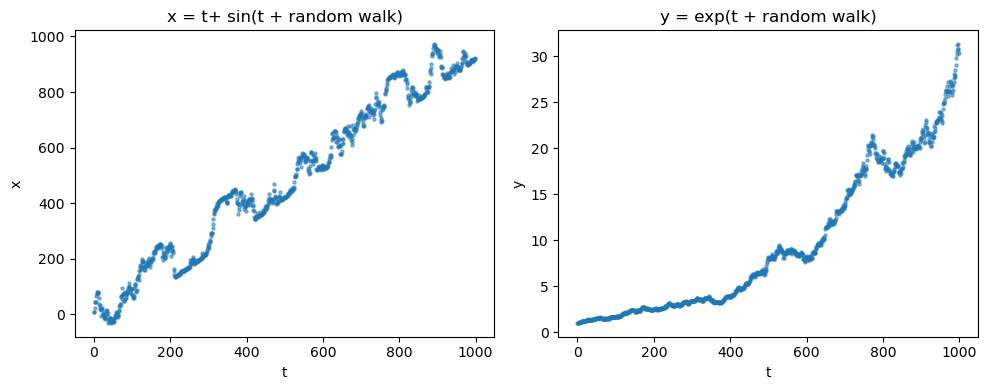

Correlation between x and y: 0.935226

Details:
Number of time points: 1000
x = t + noise (normal)
y = -t + noise (normal)

Expected correlation: close to -1 (since x increases with t, y decreases with t)


In [38]:
import numpy as np

# Set random seed for reproducibility
np.random.seed(42)

# Number of time points
n = 1000

# Generate time points
t = np.arange(n)

# Generate normal noise
noise_x = np.random.normal(0, 10, n)
noise_y = np.random.normal(0, 10, n)

# Create x and y
x = t + 80*np.sin((t+np.cumsum(noise_x))/50)
y = np.exp((t+np.cumsum(noise_y))/500)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.scatter(t, x, s=5, alpha=0.5)
plt.title("x = t+ sin(t + random walk)")
plt.xlabel("t")
plt.ylabel("x")
plt.subplot(1, 2, 2)
plt.scatter(t, y, s=5, alpha=0.5)
plt.title("y = exp(t + random walk)")
plt.xlabel("t")
plt.ylabel("y")
plt.tight_layout()
plt.show()

# Calculate correlation
correlation = np.corrcoef(x, y)[0, 1]

print(f"Correlation between x and y: {correlation:.6f}")
print(f"\nDetails:")
print(f"Number of time points: {n}")
print(f"x = t + noise (normal)")
print(f"y = -t + noise (normal)")
print(f"\nExpected correlation: close to -1 (since x increases with t, y decreases with t)")